# Vehicle Detection

## Overview

This notebook contains an implementation to identify vehicles in a video from a front-facing camera on a car. The test images and project video are located in this [repository](https://github.com/abmantha/CarND-Vehicle-Detection).

The goals / steps of this project are the following: 
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Imports

In [205]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
import time

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Load Test Images

In [222]:
%matplotlib inline
# test_images_paths = ["test_images/test*.jpg", "test_images/kitti*.png", "test_images/kitti-main*.png"]
test_images_paths = ["test_images/test*.jpg"]
test_images = glob.glob(test_images_paths[0])
# test_kitti_extracted_images = glob.glob(test_images_paths[1])
# test_kitti_main_images = glob.glob(test_images_paths[2])

cars_images_paths = ["../CarND-Data-Vehicle-Detection/vehicles/GTI_Far/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/GTI_Left/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/GTI_MiddleClose/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/GTI_Right/image*.png", 
                     "../CarND-Data-Vehicle-Detection/vehicles/KITTI_extracted/*.png"]

non_cars_images_paths = ["../CarND-Data-Vehicle-Detection/non-vehicles/Extras/extra*.png",
                         "../CarND-Data-Vehicle-Detection/non-vehicles/GTI/image*.png"]

cars = glob.glob(cars_images_paths[0])
cars.extend(glob.glob(cars_images_paths[1]))
cars.extend(glob.glob(cars_images_paths[2]))
cars.extend(glob.glob(cars_images_paths[3]))
cars.extend(glob.glob(cars_images_paths[4]))

non_cars = glob.glob(non_cars_images_paths[0])
non_cars.extend(glob.glob(non_cars_images_paths[1]))

print ("Length of cars dataset: ", len(cars))
print ("Length of non-cars dataset: ", len(non_cars))

Length of cars dataset:  8792
Length of non-cars dataset:  8968


## Histogram Extraction

In [221]:
def color_histogram(image, nbins=32, bins_range=(0,256)):
    # Compute the histogram of RGB channels
    hist_1 = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    hist_2 = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    hist_3 = np.histogram(image[:,:,2], bins=nbins, range=bins_range)

    # Generate bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1]) / 2

    # Concatenate histograms into single features vecture
    histogram_features = np.concatenate((hist_1[0], hist_2[0], hist_3[0]))
    
    return [hist_1, hist_2, hist_3], bin_centers, histogram_features

## HOG Extraction

In [196]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


## Spatial Binning

In [170]:
def spatial_binning(image, size=(32, 32)): 
    features = cv2.resize(image, size).ravel()
    return features

## Plot Utility Functions

In [171]:
def plot_color_histogram(hist_channels, bin_centers, features): 
    if len(hist_channels) != 0: 
        fig = plt.figure(figsize=(12,3))

        plt.subplot(131)
        plt.bar(bin_centers, hist_channels[0][0])
        plt.xlim(0, 256)
        plt.title('Channel 1 Histogram')
        
        plt.subplot(132)
        plt.bar(bin_centers, hist_channels[1][0])
        plt.xlim(0, 256)
        plt.title('Channel 2 Histogram')
        
        plt.subplot(133)
        plt.bar(bin_centers, hist_channels[2][0])
        plt.xlim(0, 256)
        plt.title('Channel 3 Histogram')
        
        plt.show()
    else: 
        print ("Error with your function")
        
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]): 
    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)
    
    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    
    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    
    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), 
        edgecolors='none'
    )
    
    return ax

## Data Exploration

In [172]:
def generate_dataset_dict(car_list, not_car_list): 
    example_image = cv2.imread(car_list[0])
    data_dict = {}    
    data_dict["n_cars"] = len(car_list)
    data_dict["n_not_cars"] = len(not_car_list)
    data_dict["image_shape"] = example_image.shape
    data_dict["data_type"] = example_image.dtype
    return data_dict

## Plotting

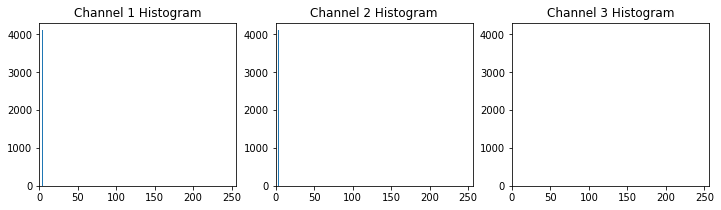

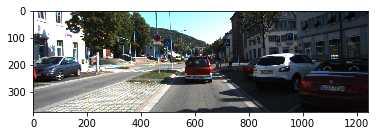

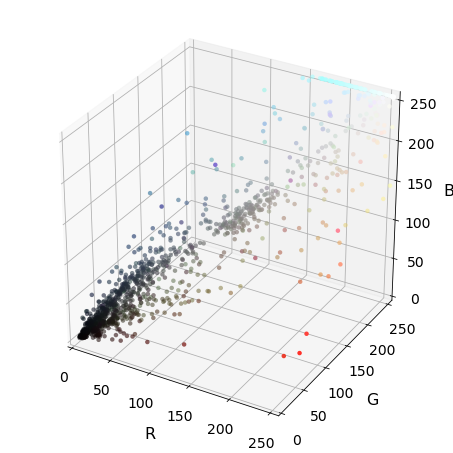

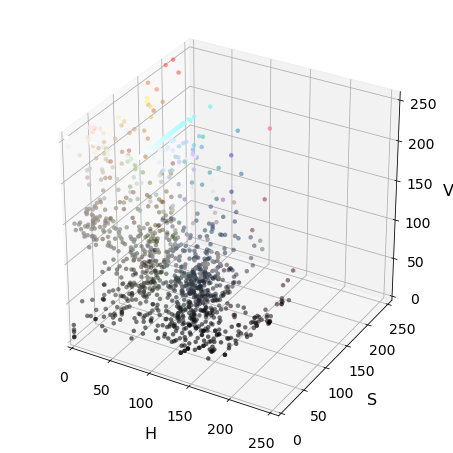

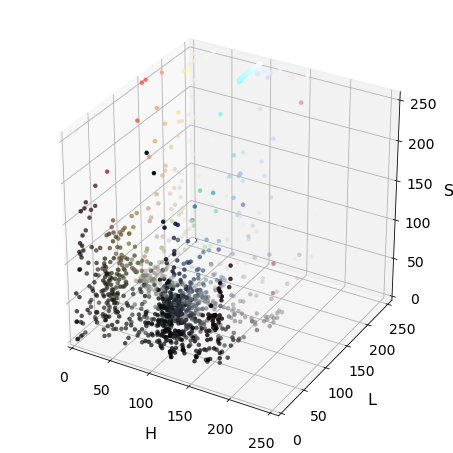

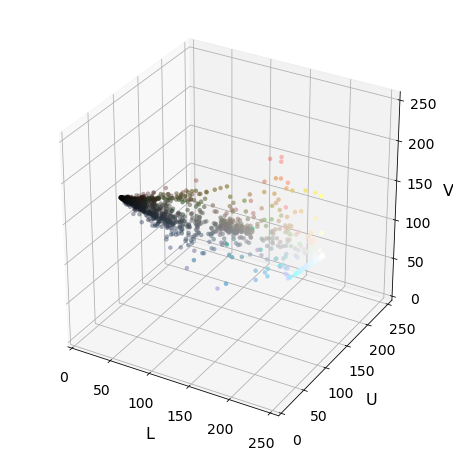

In [173]:
image = mpimg.imread(fname)
hist_channels, bin_centers, feature_vec = color_histogram(image, 32, (0, 256))    
plot_color_histogram(hist_channels, bin_centers, feature_vec)

img_name = kitti_extracted_images[0]
img = cv2.imread(img_name)
copy = np.copy(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

scale = max(copy.shape[0], copy.shape[1], 64) / 64
img_small = cv2.resize(copy, (np.int(copy.shape[1] / scale), np.int(copy.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2Luv)
img_small_rgb = img_small_RGB / 255.

plot3d(img_small_RGB, img_small_rgb)
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

## Pipeline Utilities

In [223]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# def single_image_features(image, color_space='RGB', 
#                           spatial_size=(32, 32), hist_bins=32, 
#                           orient=9, pix_per_cell=8, cell_per_block=2,
#                           hog_channel=0, spatial_feat=True, hist_feat=True,
#                           hog_feat=True):
#     image_features = []
#     if color_space != 'RGB':
#         if color_space == 'HSV':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#         elif color_space == 'LUV':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#         elif color_space == 'HLS':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#         elif color_space == 'YUV':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#         elif color_space == 'YCrCb':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#     else: feature_image = np.copy(image)     
    
#     if spatial_feat: 
#         spatial_features = spatial_binning(feature_image, size=spatial_size)
#         image_features.append(spatial_features)
        
#     if hist_feat:
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         image_features.append(hist_features)
        
#     if hog_feat:
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.extend(get_hog_features(feature_image[:, :, channel],
#                                     orient, pix_per_cell, cell_per_block,
#                                     vis=False, feature_vec=True))
#         else: 
#             hog_features = get_hog_features(feature_image[:, :, hog_channel],
#                                             orient, pix_per_cell, cell_per_block,
#                                             vis=False, feature_vec=True)
#         image_features.append(hog_features)
        
#     return np.concatenate(image_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    print ("Drawing boxes")
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Single Image Prediction

(10992,)
(10992,)
Using: 9 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 10992
0.36 Seconds to train SVC...
Test Accuracy of SVC =  0.995
Drawing boxes


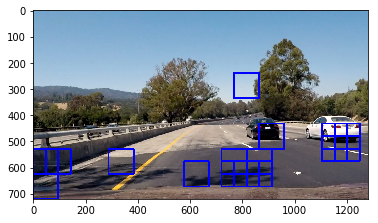

In [224]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
sample_cars = cars[0:sample_size]
sample_non_cars = non_cars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
image = mpimg.imread(test_images[0])
image_shape = (image.shape[1], image.shape[0])
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(sample_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(sample_non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print (car_features[0].shape)
print (notcar_features[0].shape)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread(test_images[3])
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


## All together now -- normalization 

In [ ]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from sklearn.preprocessing import StandardScaler
# import glob

# # Define a function to compute binned color features  
# def bin_spatial(img, c_space='RGB', size=(32, 32)):
#     if c_space != 'RGB':
#         if c_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#         elif c_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
#         elif c_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
#         elif c_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
#     else: 
#         feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      

#     # Use cv2.resize().ravel() to create the feature vector
#     features = cv2.resize(feature_image, size).ravel() 
#     # Return the feature vector
#     return feature_image, features

# # Define a function to compute color histogram features  
# def color_hist(img, nbins=32, bins_range=(0, 256)):
#     # Compute the histogram of the color channels separately
#     channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
#     channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
#     channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
#     # Concatenate the histograms into a single feature vector
#     hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#     # Return the individual histograms, bin_centers and feature vector
#     return hist_features

# ###### TODO ###########
# # Define a function to extract features from a list of images
# # Have this function call bin_spatial() and color_hist()
# def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256)):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for i in imgs:
#         # Read in each one by one
#         image = cv2.imread(i)
#         # apply color conversion if other than 'RGB'
#         # Apply bin_spatial() to get spatial color features
#         feature_image, spatial_features = bin_spatial(image, c_space=cspace, size=spatial_size)
#         # Apply color_hist() to get color histogram features
#         hist_features = color_hist(feature_image, hist_bins, hist_range)
#         # Append the new feature vector to the features list
#         features.append(np.concatenate((spatial_features, hist_features)))
#     # Return list of feature vectors
#     return features

# images = glob.glob('*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)
        
# car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))
# notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))

# if len(car_features) > 0:
#     # Create an array stack of feature vectors
#     X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
#     # Fit a per-column scaler
#     X_scaler = StandardScaler().fit(X)
#     # Apply the scaler to X
#     scaled_X = X_scaler.transform(X)
#     car_ind = np.random.randint(0, len(cars))
#     # Plot an example of raw and scaled features
#     fig = plt.figure(figsize=(12,4))
#     plt.subplot(131)
#     plt.imshow(mpimg.imread(cars[car_ind]))
#     plt.title('Original Image')
#     plt.subplot(132)
#     plt.plot(X[car_ind])
#     plt.title('Raw Features')
#     plt.subplot(133)
#     plt.plot(scaled_X[car_ind])
#     plt.title('Normalized Features')
#     fig.tight_layout()
# else: 
#     print('Your function only returns empty feature vectors...')

## Color Classify

In [ ]:
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2
# import glob
# import time
# from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler
# # NOTE: the next import is only valid 
# # for scikit-learn version <= 0.17
# # if you are using scikit-learn >= 0.18 then use this:
# # from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# # Define a function to compute binned color features  
# def bin_spatial(img, size=(32, 32)):
#     # Use cv2.resize().ravel() to create the feature vector
#     features = cv2.resize(img, size).ravel() 
#     # Return the feature vector
#     return features

# # Define a function to compute color histogram features  
# def color_hist(img, nbins=32, bins_range=(0, 256)):
#     # Compute the histogram of the color channels separately
#     channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
#     channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
#     channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
#     # Concatenate the histograms into a single feature vector
#     hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#     # Return the individual histograms, bin_centers and feature vector
#     return hist_features

# # Define a function to extract features from a list of images
# # Have this function call bin_spatial() and color_hist()
# def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256)):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         # Read in each one by one
#         image = mpimg.imread(file)
#         # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#         else: feature_image = np.copy(image)      
#         # Apply bin_spatial() to get spatial color features
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         # Apply color_hist() also with a color space option now
#         hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
#         # Append the new feature vector to the features list
#         features.append(np.concatenate((spatial_features, hist_features)))
#     # Return list of feature vectors
#     return features


# # Read in car and non-car images
# images = glob.glob('*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

# # TODO play with these values to see how your classifier
# # performs under different binning scenarios
# spatial = 32
# histbin = 32

# car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
#                         hist_bins=histbin, hist_range=(0, 256))
# notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
#                         hist_bins=histbin, hist_range=(0, 256))

# # Create an array stack of feature vectors
# X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# # Define the labels vector
# y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

# print('Using spatial binning of:',spatial,
#     'and', histbin,'histogram bins')
# print('Feature vector length:', len(X_train[0]))
# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# HOG Classify

In [59]:
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2
# import glob
# import time
# from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler
# from skimage.feature import hog
# # NOTE: the next import is only valid for scikit-learn version <= 0.17
# # for scikit-learn >= 0.18 use:
# # from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# # Define a function to return HOG features and visualization
# def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
#                         vis=False, feature_vec=True):
#     # Call with two outputs if vis==True
#     if vis == True:
#         features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                                   visualise=vis, feature_vector=feature_vec)
#         return features, hog_image
#     # Otherwise call with one output
#     else:      
#         features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                        cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                        visualise=vis, feature_vector=feature_vec)
#         return features

# # Define a function to extract features from a list of images
# # Have this function call bin_spatial() and color_hist()
# def extract_features(imgs, cspace='RGB', orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         # Read in each one by one
#         image = mpimg.imread(file)
#         # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif cspace == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else: feature_image = np.copy(image)      

#         # Call get_hog_features() with vis=False, feature_vec=True
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))
#             hog_features = np.ravel(hog_features)        
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         # Append the new feature vector to the features list
#         features.append(hog_features)
#     # Return list of feature vectors
#     return features


# # Divide up into cars and notcars
# images = glob.glob('*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

# # Reduce the sample size because HOG features are slow to compute
# # The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

# ### TODO: Tweak these parameters and see how the results change.
# colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 8
# pix_per_cell = 8
# cell_per_block = 4
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# t=time.time()
# car_features = extract_features(cars, cspace=colorspace, orient=orient, 
#                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel)
# notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
#                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to extract HOG features...')
# # Create an array stack of feature vectors
# X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# # Define the labels vector
# y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

# print('Using:',orient,'orientations',pix_per_cell,
#     'pixels per cell and', cell_per_block,'cells per block')
# print('Feature vector length:', len(X_train[0]))
# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Spatial, Hist, and HOG Combined Classification

In [ ]:
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2
# import glob
# import time
# from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler
# from skimage.feature import hog
# from lesson_functions import *
# # NOTE: the next import is only valid for scikit-learn version <= 0.17
# # for scikit-learn >= 0.18 use:
# # from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# # Define a function to extract features from a single image window
# # This function is very similar to extract_features()
# # just for a single image rather than list of images
# def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):    
#     #1) Define an empty list to receive features
#     img_features = []
#     #2) Apply color conversion if other than 'RGB'
#     if color_space != 'RGB':
#         if color_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         elif color_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#         elif color_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         elif color_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#         elif color_space == 'YCrCb':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     else: feature_image = np.copy(img)      
#     #3) Compute spatial features if flag is set
#     if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         #4) Append features to list
#         img_features.append(spatial_features)
#     #5) Compute histogram features if flag is set
#     if hist_feat == True:
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         #6) Append features to list
#         img_features.append(hist_features)
#     #7) Compute HOG features if flag is set
#     if hog_feat == True:
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.extend(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))      
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         #8) Append features to list
#         img_features.append(hog_features)

#     #9) Return concatenated array of features
#     return np.concatenate(img_features)

# # Define a function you will pass an image 
# # and the list of windows to be searched (output of slide_windows())
# def search_windows(img, windows, clf, scaler, color_space='RGB', 
#                     spatial_size=(32, 32), hist_bins=32, 
#                     hist_range=(0, 256), orient=9, 
#                     pix_per_cell=8, cell_per_block=2, 
#                     hog_channel=0, spatial_feat=True, 
#                     hist_feat=True, hog_feat=True):

#     #1) Create an empty list to receive positive detection windows
#     on_windows = []
#     #2) Iterate over all windows in the list
#     for window in windows:
#         #3) Extract the test window from original image
#         test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
#         #4) Extract features for that window using single_img_features()
#         features = single_img_features(test_img, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)
#         #5) Scale extracted features to be fed to classifier
#         test_features = scaler.transform(np.array(features).reshape(1, -1))
#         #6) Predict using your classifier
#         prediction = clf.predict(test_features)
#         #7) If positive (prediction == 1) then save the window
#         if prediction == 1:
#             on_windows.append(window)
#     #8) Return windows for positive detections
#     return on_windows
    
    
# # Read in cars and notcars
# images = glob.glob('*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

# # Reduce the sample size because
# # The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

# ### TODO: Tweak these parameters and see how the results change.
# image = mpimg.imread('bbox-example-image.jpg')
# image_shape = (image.shape[1], image.shape[0])
# color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9  # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 4 # HOG cells per block
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# spatial_size = (8, 8) # Spatial binning dimensions
# hist_bins = 32    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = False # Histogram features on or off
# hog_feat = True # HOG features on or off
# y_start_stop = [None, None] # Min and max in y to search in slide_window()

# car_features = extract_features(cars, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)
# notcar_features = extract_features(notcars, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)

# X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# # Define the labels vector
# y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

# print('Using:',orient,'orientations',pix_per_cell,
#     'pixels per cell and', cell_per_block,'cells per block')
# print('Feature vector length:', len(X_train[0]))
# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()

# image = mpimg.imread('bbox-example-image.jpg')
# draw_image = np.copy(image)

# # Uncomment the following line if you extracted training
# # data from .png images (scaled 0 to 1 by mpimg) and the
# # image you are searching is a .jpg (scaled 0 to 255)
# #image = image.astype(np.float32)/255

# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(96, 96), xy_overlap=(0.5, 0.5))

# hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)                       

# window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# plt.imshow(window_img)

# Complete Pipeline

In [60]:
def pipeline(image): 
    return image

# Video Playback

### Test Video

In [69]:
test_video_outname = "test_video_with_detection.mp4"
test_video = VideoFileClip("test_video.mp4")
test_video_updated = test_video.fl_image(pipeline)
%time test_video_updated.write_videofile(test_video_outname, audio=False)

[MoviePy] >>>> Building video test_video_with_detection.mp4
[MoviePy] Writing video test_video_with_detection.mp4


 97%|█████████▋| 38/39 [00:00<00:00, 148.54it/s]     | 12/39 [00:00<00:00, 117.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_with_detection.mp4 

CPU times: user 48.8 ms, sys: 52.2 ms, total: 101 ms
Wall time: 953 ms


In [70]:
HTML("""
<video width="480" height="275" controls>
    <source src="{0}">
</video>
""".format(test_video_outname))

# Project Video

In [73]:
project_video_outname = "project_video_with_detection.mp4"
project_video = VideoFileClip("project_video.mp4")
project_video_updated = project_video.fl_image(pipeline)
%time project_video_updated.write_videofile(project_video_outname, audio=False)

[MoviePy] >>>> Building video project_video_with_detection.mp4
[MoviePy] Writing video project_video_with_detection.mp4


100%|█████████▉| 1260/1261 [00:22<00:00, 56.41it/s]    | 12/1261 [00:00<00:10, 117.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_detection.mp4 

CPU times: user 1.68 s, sys: 1.35 s, total: 3.03 s
Wall time: 23.1 s


In [72]:
HTML("""
<video width="480" height="275" controls>
    <source src="{0}">
</video>
""".format(project_video_outname))

In [ ]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from sklearn.preprocessing import StandardScaler
# import glob

# # Define a function to compute binned color features  
# def bin_spatial(img, c_space='RGB', size=(32, 32)):
#     if c_space != 'RGB':
#         if c_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#         elif c_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
#         elif c_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
#         elif c_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
#     else: 
#         feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      

#     # Use cv2.resize().ravel() to create the feature vector
#     features = cv2.resize(feature_image, size).ravel() 
#     # Return the feature vector
#     return feature_image, features

# # Define a function to compute color histogram features  
# def color_hist(img, nbins=32, bins_range=(0, 256)):
#     # Compute the histogram of the color channels separately
#     channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
#     channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
#     channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
#     # Concatenate the histograms into a single feature vector
#     hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#     # Return the individual histograms, bin_centers and feature vector
#     return hist_features

# ###### TODO ###########
# # Define a function to extract features from a list of images
# # Have this function call bin_spatial() and color_hist()
# def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256)):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for i in imgs:
#         # Read in each one by one
#         image = cv2.imread(i)
#         # apply color conversion if other than 'RGB'
#         # Apply bin_spatial() to get spatial color features
#         feature_image, spatial_features = bin_spatial(image, c_space=cspace, size=spatial_size)
#         # Apply color_hist() to get color histogram features
#         hist_features = color_hist(feature_image, hist_bins, hist_range)
#         # Append the new feature vector to the features list
#         features.append(np.concatenate((spatial_features, hist_features)))
#     # Return list of feature vectors
#     return features

# images = glob.glob('*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)
        
# car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))
# notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))

# if len(car_features) > 0:
#     # Create an array stack of feature vectors
#     X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
#     # Fit a per-column scaler
#     X_scaler = StandardScaler().fit(X)
#     # Apply the scaler to X
#     scaled_X = X_scaler.transform(X)
#     car_ind = np.random.randint(0, len(cars))
#     # Plot an example of raw and scaled features
#     fig = plt.figure(figsize=(12,4))
#     plt.subplot(131)
#     plt.imshow(mpimg.imread(cars[car_ind]))
#     plt.title('Original Image')
#     plt.subplot(132)
#     plt.plot(X[car_ind])
#     plt.title('Raw Features')
#     plt.subplot(133)
#     plt.plot(scaled_X[car_ind])
#     plt.title('Normalized Features')
#     fig.tight_layout()
# else: 
#     print('Your function only returns empty feature vectors...')